In [ ]:
from nba_api.stats.endpoints import LeagueDashPlayerStats
import time
from unidecode import unidecode
import pandas as pd
import os

home_dir = "/Users/neeldavuluri"
output_path = os.path.join(home_dir, "player_stats.csv")

print("Saving to:", output_path)

#base stats
stats_base = LeagueDashPlayerStats(
    season='2024-25',
    per_mode_detailed='PerGame'
).get_data_frames()[0]
time.sleep(1)

#advanced stats
stats_adv = LeagueDashPlayerStats(
    season='2024-25',
    per_mode_detailed='PerGame',
    measure_type_detailed_defense='Advanced'
).get_data_frames()[0]
time.sleep(1)

stats_base['PLAYER_NAME'] = stats_base['PLAYER_NAME'].apply(unidecode)
stats_adv['PLAYER_NAME'] = stats_adv['PLAYER_NAME'].apply(unidecode)

#merge base and advanced
nba_df = stats_base.merge(
    stats_adv,
    on='PLAYER_ID',
    suffixes=('_base', '_adv')
)

#drop duplicate names
if 'PLAYER_NAME_adv' in nba_df.columns:
    nba_df.drop(columns=['PLAYER_NAME_adv'], inplace=True)
    nba_df.rename(columns={'PLAYER_NAME_base': 'PLAYER_NAME'}, inplace=True)

nba_df.to_csv(output_path, index=False)

print(f"Saved data to: {output_path}")

Saving to: /Users/neeldavuluri/player_stats.csv
Saved data to: /Users/neeldavuluri/player_stats.csv


In [ ]:
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
import os

def spider(url):
    useragent = f'ds6021rt/0.0 (yht7nf@virginia.edu) python-requests/{requests.__version__}'
    headers = {'User-Agent': useragent, 'From': 'yht7nf@virginia.edu'}

    r = requests.get(url, headers=headers)
    mysoup = BeautifulSoup(r.text, 'html.parser')

    #extract player names
    player_list = mysoup.select('td:has(a)')
    player_list = player_list[::2]     #ESPN double-lists players
    players = [td.find("a").get_text(strip=True) for td in player_list]

    #extract salaries
    salaries = mysoup.select('td[style*="text-align:right"]:not([width])')
    salaries = [td.get_text(strip=True) for td in salaries]

    df = pd.DataFrame({
        "PLAYER_NAME": players,
        "SALARY": salaries
    })
    return df


if __name__ == "__main__":
    new_df = pd.DataFrame()

    for i in range(1, 14):
        url = f"https://www.espn.com/nba/salaries/_/year/2025/page/{i}"
        df = spider(url)
        new_df = pd.concat([new_df, df], ignore_index=True)

    output_path = "/Users/neeldavuluri/24-25_salaries.csv"
    new_df.to_csv(output_path, index=False)

    print(f"Saved to: {output_path}")

Saved to: /Users/neeldavuluri/24-25_salaries.csv


In [ ]:
import pandas as pd
import numpy as np

nba = pd.read_csv('/Users/neeldavuluri/player_stats.csv')
salaries = pd.read_csv('/Users/neeldavuluri/24-25_salaries.csv')

nba['helper'] = nba['PLAYER_NAME'].str.lower()\
    .str.replace('.', '', regex=False)\
        .str.replace("'", '', regex=False)\
            .str.replace(' ', '', regex=False)
            
salaries['helper'] = salaries['PLAYER_NAME'].str.lower()\
    .str.replace('.', '', regex=False)\
        .str.replace("'", '', regex=False)\
            .str.replace(' ', '', regex=False)

merged = pd.merge(
    nba, 
    salaries[['helper', 'SALARY']],
    on='helper',
    how='outer', 
    validate='one_to_one', 
    indicator=True
)

merged = merged[merged['_merge'] == 'both']
merged = merged.drop(columns=['helper', '_merge'])

merged['SALARY'] = merged['SALARY']\
    .astype(str).str.replace('$', '', regex=False)\
        .str.replace(',', '', regex=False)
merged['SALARY'] = pd.to_numeric(merged['SALARY'], errors='coerce')

merged.to_csv('/Users/neeldavuluri/nba_data_with_salaries.csv', index=False)

In [5]:
merged.columns

Index(['PLAYER_ID', 'PLAYER_NAME', 'NICKNAME_base', 'TEAM_ID_base',
       'TEAM_ABBREVIATION_base', 'AGE_base', 'GP_base', 'W_base', 'L_base',
       'W_PCT_base',
       ...
       'PACE_RANK', 'sp_work_PACE_RANK', 'PIE_RANK', 'FGM_RANK_adv',
       'FGA_RANK_adv', 'FGM_PG_RANK', 'FGA_PG_RANK', 'FG_PCT_RANK_adv',
       'TEAM_COUNT_adv', 'SALARY'],
      dtype='object', length=145)

numeric columns only for the features, select good PCA features

In [27]:
df = merged.copy()

#numeric-only
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

#remove salary and IDs from PCA 
exclude = [
    "PLAYER_ID",
    "TEAM_ID_base",
    "TEAM_ID_adv" if "TEAM_ID_adv" in df.columns else None,
    "SALARY"
]
exclude = [x for x in exclude if x is not None]

#remove rank columns
rank_cols = [c for c in numeric_cols if "RANK" in c]

pca_features = [c for c in numeric_cols if c not in exclude and c not in rank_cols]

print(len(pca_features), "features selected for PCA")
pca_features

71 features selected for PCA


['AGE_base',
 'GP_base',
 'W_base',
 'L_base',
 'W_PCT_base',
 'MIN_base',
 'FGM_base',
 'FGA_base',
 'FG_PCT_base',
 'FG3M',
 'FG3A',
 'FG3_PCT',
 'FTM',
 'FTA',
 'FT_PCT',
 'OREB',
 'DREB',
 'REB',
 'AST',
 'TOV',
 'STL',
 'BLK',
 'BLKA',
 'PF',
 'PFD',
 'PTS',
 'PLUS_MINUS',
 'NBA_FANTASY_PTS',
 'DD2',
 'TD3',
 'WNBA_FANTASY_PTS',
 'TEAM_COUNT_base',
 'AGE_adv',
 'GP_adv',
 'W_adv',
 'L_adv',
 'W_PCT_adv',
 'MIN_adv',
 'E_OFF_RATING',
 'OFF_RATING',
 'sp_work_OFF_RATING',
 'E_DEF_RATING',
 'DEF_RATING',
 'sp_work_DEF_RATING',
 'E_NET_RATING',
 'NET_RATING',
 'sp_work_NET_RATING',
 'AST_PCT',
 'AST_TO',
 'AST_RATIO',
 'OREB_PCT',
 'DREB_PCT',
 'REB_PCT',
 'TM_TOV_PCT',
 'E_TOV_PCT',
 'EFG_PCT',
 'TS_PCT',
 'USG_PCT',
 'E_USG_PCT',
 'E_PACE',
 'PACE',
 'PACE_PER40',
 'sp_work_PACE',
 'PIE',
 'POSS',
 'FGM_adv',
 'FGA_adv',
 'FGM_PG',
 'FGA_PG',
 'FG_PCT_adv',
 'TEAM_COUNT_adv']

In [ ]:
pca_features = [
    #volume scoring and atte,pts
    'PTS', 'FGA_base', 'FG3A', 'FTM', 'FTA',

    #efficiency
    'TS_PCT', 'EFG_PCT',

    #rebounding
    'OREB', 'DREB', 'OREB_PCT', 'DREB_PCT',

    #playmaking
    'AST', 'AST_TO',

    #turnovers and fouls
    'TOV', 'PF',

    #defense
    'STL', 'BLK', 'DEF_RATING',

    #usage and pace
    'USG_PCT', 'PACE',

    #impact on team
    'PLUS_MINUS'
]

min 15mpg requirement

In [29]:
df_model = df[df["MIN_base"] >= 15].copy()

#drop missing values
df_model = df_model.dropna(subset=pca_features)

scale data

In [30]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_model[pca_features])

fit PCA (with all components first)

In [31]:
from sklearn.decomposition import PCA

pca = PCA(n_components=None, random_state=0)
X_pca = pca.fit_transform(X_scaled)

explained = pca.explained_variance_ratio_

explaining the variance

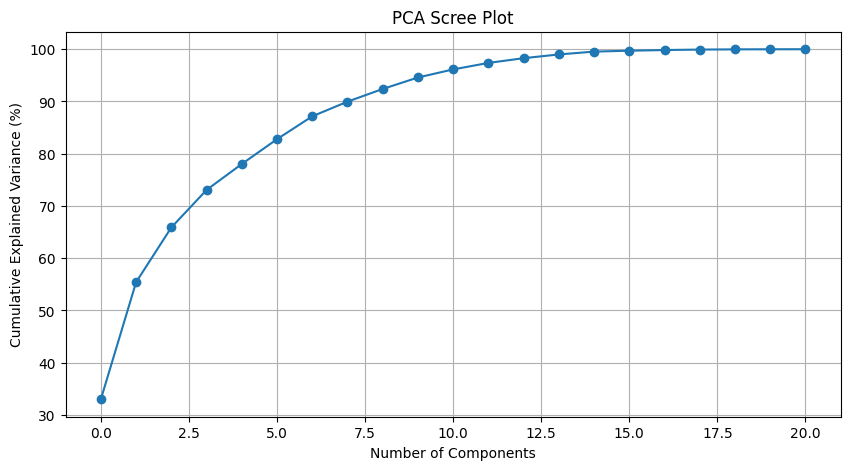

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(np.cumsum(explained)*100, marker='o')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance (%)")
plt.title("PCA Scree Plot")
plt.grid(True)
plt.show()

95% of variance explained by 10 components, 40% with PC1, 80% with PC5

loading matrix

In [34]:
loadings = pd.DataFrame(    
    pca.components_.T,
    index=pca_features,
    columns=[f"PC{i+1}" for i in range(pca.n_components_)]
)

loadings_top5 = loadings.iloc[:, :5]
loadings_top5

,PC1,PC2,PC3,PC4,PC5
PTS,0.366933,-0.015873,0.039960,0.127760,-0.057759
FGA_base,0.360836,-0.069820,-0.012224,0.067296,-0.081728
FG3A,0.209722,-0.267116,0.067746,0.134416,-0.149694
FTM,0.349818,0.009559,-0.012546,0.072168,-0.067740
FTA,0.346275,0.047827,-0.031986,0.047901,-0.059673
TS_PCT,0.046279,0.250262,0.357405,0.479384,0.149419
EFG_PCT,-0.021330,0.263052,0.359497,0.450092,0.162808
OREB,0.034741,0.417442,-0.096004,-0.096146,0.024688
DREB,0.222402,0.308648,-0.066418,-0.077103,0.026450
OREB_PCT,-0.063225,0.413347,-0.088524,-0.074491,0.007058


In [35]:
for i in range(5):
    print(f"\nTop features for PC{i+1}:")
    print(loadings_top5.iloc[:, i].sort_values(ascending=False).head(10))
    print(loadings_top5.iloc[:, i].sort_values().head(10))


Top features for PC1:
PTS         0.366933
FGA_base    0.360836
FTM         0.349818
FTA         0.346275
TOV         0.344833
USG_PCT     0.336276
AST         0.299013
DREB        0.222402
FG3A        0.209722
STL         0.186304
Name: PC1, dtype: float64
OREB_PCT     -0.063225
EFG_PCT      -0.021330
AST_TO       -0.008358
PACE         -0.002120
DEF_RATING    0.027127
OREB          0.034741
TS_PCT        0.046279
DREB_PCT      0.064507
BLK           0.070008
PLUS_MINUS    0.079881
Name: PC1, dtype: float64

Top features for PC2:
OREB          0.417442
OREB_PCT      0.413347
DREB_PCT      0.384951
BLK           0.323519
DREB          0.308648
EFG_PCT       0.263052
TS_PCT        0.250262
PF            0.177364
PLUS_MINUS    0.096369
FTA           0.047827
Name: PC2, dtype: float64
FG3A         -0.267116
AST_TO       -0.166687
AST          -0.112504
DEF_RATING   -0.080459
USG_PCT      -0.070628
FGA_base     -0.069820
STL          -0.049706
TOV          -0.023928
PACE         -0.019871

In [ ]:
from sklearn.decomposition import PCA

pcs_to_keep = 5
pca = PCA(n_components=pcs_to_keep)

X_pca = pca.fit_transform(X_scaled)
pc_cols = [f"PC{i+1}" for i in range(pcs_to_keep)]
pca_df = pd.DataFrame(X_pca, columns=pc_cols)
df_model_with_pca = pd.concat([df_model.reset_index(drop=True), pca_df], axis=1)
df_model_with_pca.head()
df_model_with_pca.columns[-10:]

Index(['FGM_PG_RANK', 'FGA_PG_RANK', 'FG_PCT_RANK_adv', 'TEAM_COUNT_adv',
       'SALARY', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5'],
      dtype='object')

In [38]:
pca_output = df_model_with_pca[["PLAYER_NAME"] + pc_cols]
pca_output
#pca_output.to_csv("/Users/neeldavuluri/pca_components.csv", index=False)

,PLAYER_NAME,PC1,PC2,PC3,PC4,PC5
0,Aaron Gordon,0.321261,0.800106,1.828359,1.503735,0.322984
1,Aaron Nesmith,-0.793056,0.651003,1.593821,1.163314,-0.024253
2,Aaron Wiggins,-1.039946,-0.219750,2.214479,-0.040218,-0.668549
3,Adem Bona,-2.609971,4.044603,0.232401,2.789126,0.284725
4,Ajay Mitchell,-2.605728,-0.816511,2.450279,-1.061838,-0.991645
...,...,...,...,...,...,...
341,Zach Collins,-2.223666,1.864840,-0.024374,-0.133201,0.525391
342,Zach Edey,-1.134255,5.616202,-0.774069,-0.362397,0.731428
343,Zach LaVine,3.194461,-1.394385,0.306396,2.759545,0.295113
344,Ziaire Williams,-0.677810,-0.259922,-1.827828,0.250163,-0.986967
